In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn.init as init

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Carregando MotionSense Dataset

In [2]:
path = 'dataset/motion_sense/A_DeviceMotion_data/A_DeviceMotion_data/'

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_directories = [s for s in list_of_directories if '.DS_Store' not in s]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

# Iterating through the directories and appending the dataframes for each subject in each of the trials to a list for further use.

for i in list_of_directories:
    list_of_csv = os.listdir(i)
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[4].split('_')[0]
        k['trial'] = int(i.split('/')[4].split('_')[1])
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)

# Creating one big dataframe (df) from the list of all individual dataframes. Dropping unnecessary columns and renaming the ones for rotation.

df = pd.concat(list_of_dfs).set_index('time')
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

df.drop(columns=['accel_norm', 'subject'], inplace=True)

In [3]:
df

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,activity,trial
time,,,,,,,,
0,0.364487,0.487076,0.623337,0.965962,-1.491572,2.297339,wlk,15
1,0.295623,2.733551,1.545837,-1.227649,0.278047,1.221141,wlk,15
2,0.629455,4.016220,0.630158,-1.391025,-0.103284,-1.040938,wlk,15
3,0.430603,1.410126,0.385712,-1.148514,-2.495525,-1.608745,wlk,15
4,0.166397,-0.128006,0.818359,-0.843432,-2.442407,-1.304375,wlk,15
...,...,...,...,...,...,...,...,...
1112,-0.206253,0.891907,-0.074829,-0.259963,-0.007337,-0.511457,dws,11
1113,-0.170975,0.924530,-0.079544,-0.204820,0.143787,-0.523016,dws,11
1114,-0.122223,0.951935,-0.152131,-0.116265,0.144543,-0.522399,dws,11


In [4]:
def create_lag_features(df, n, cols):
    """

    Parameters
    ----------
    n : int
        amount of lag features
    cols : list
        list of columns to lag

    Returns
    -------
    pd.DataFrame
        a dataframe with the list of columns lagged n times

    """

    lag_features = n
    lag_dfs = [df]

    for col in cols:
        for lag in range(1, lag_features + 1):
            lagged = df[col].shift(lag)
            lagged.name = f'{col}_lag{lag}'
            lag_dfs.append(lagged)
    
    lag_df = pd.concat(lag_dfs, axis=1)
    lag_df = lag_df.drop(range(lag_features))
    lag_df = lag_df.sort_index(axis=1)
    return lag_df

In [5]:
colunas = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
lag_df = create_lag_features(df, 59, colunas)
lag_df.head()

,accel_x,accel_x_lag1,accel_x_lag10,accel_x_lag11,accel_x_lag12,accel_x_lag13,accel_x_lag14,accel_x_lag15,accel_x_lag16,accel_x_lag17,...,gyro_z_lag55,gyro_z_lag56,gyro_z_lag57,gyro_z_lag58,gyro_z_lag59,gyro_z_lag6,gyro_z_lag7,gyro_z_lag8,gyro_z_lag9,trial
time,,,,,,,,,,,,,,,,,,,,,
59,-0.173843,3.030884,0.201783,0.147903,0.147903,0.246460,0.324143,0.399186,0.451401,0.240341,...,-1.304375,-1.608745,-1.040938,1.221141,2.297339,-1.336042,-0.445329,1.403452,1.741341,15
60,-0.062362,-0.173843,0.273285,0.201783,0.147903,0.147903,0.246460,0.324143,0.399186,0.451401,...,0.212782,-1.304375,-1.608745,-1.040938,1.221141,-1.385512,-1.336042,-0.445329,1.403452,15
61,0.287216,-0.062362,0.295242,0.273285,0.201783,0.147903,0.147903,0.246460,0.324143,0.399186,...,1.929851,0.212782,-1.304375,-1.608745,-1.040938,-0.778153,-1.385512,-1.336042,-0.445329,15
62,0.437302,0.287216,0.790329,0.295242,0.273285,0.201783,0.147903,0.147903,0.246460,0.324143,...,-0.227869,1.929851,0.212782,-1.304375,-1.608745,0.949150,-0.778153,-1.385512,-1.336042,15
63,0.629730,0.437302,0.453827,0.790329,0.295242,0.273285,0.201783,0.147903,0.147903,0.246460,...,-1.439105,-0.227869,1.929851,0.212782,-1.304375,1.726520,0.949150,-0.778153,-1.385512,15


In [6]:
# pegando só 10% das amostras
df_90, df_10 = train_test_split(lag_df, test_size=0.1, random_state=42) # dataframes de treino e validacao
lag_df = df_10

In [7]:
# pegando só 10% das amostras
lag_df.head()

,accel_x,accel_x_lag1,accel_x_lag10,accel_x_lag11,accel_x_lag12,accel_x_lag13,accel_x_lag14,accel_x_lag15,accel_x_lag16,accel_x_lag17,...,gyro_z_lag55,gyro_z_lag56,gyro_z_lag57,gyro_z_lag58,gyro_z_lag59,gyro_z_lag6,gyro_z_lag7,gyro_z_lag8,gyro_z_lag9,trial
time,,,,,,,,,,,,,,,,,,,,,
2906,-0.533981,-0.592331,-0.015869,-0.087586,-0.159591,-0.209534,-0.230744,-0.242233,-0.260270,-0.243545,...,0.231390,0.298413,-0.127559,-0.179233,-0.063365,-0.182700,-0.067601,0.082212,0.271338,8
5027,-0.401428,-0.367111,-0.842606,-0.743896,-0.649628,-0.566971,-0.680084,-0.692856,-0.562210,-0.463668,...,-0.628167,-0.823068,-0.894360,-1.184562,-1.070256,-0.840679,-0.358300,-0.187651,-0.213790,7
7552,-0.210480,-0.187119,-0.229538,-0.232605,-0.237884,-0.219696,-0.204254,-0.181046,-0.198319,-0.220978,...,-0.015230,-0.004613,0.001717,0.001647,-0.001604,0.005787,0.003789,-0.002528,-0.009908,6
2539,-0.555572,-0.090165,0.104187,0.104187,0.167038,0.200592,0.287781,0.287903,0.284927,0.239471,...,2.980016,2.634362,1.774724,0.886945,0.287684,0.082029,-0.302836,-0.773537,-1.164659,15
1887,0.099884,0.098801,0.133972,0.117462,0.113388,0.119217,0.123154,0.123626,0.122620,0.123428,...,-0.008188,-0.003898,-0.004984,-0.012460,-0.018899,-0.001880,0.002528,0.013411,0.027433,6


In [6]:
lag_df.shape

(1391625, 362)

In [7]:
train = lag_df[(lag_df.trial < 10)]
test = lag_df[(lag_df.trial > 10)]

In [8]:
train_df, val_df = train_test_split(train, test_size=0.3, random_state=42) # dataframes de treino e validacao

In [9]:
print(train_df.shape, val_df.shape)

(748091, 362) (320611, 362)


In [10]:
X_train = train_df.drop(columns=['trial', 'activity'])
y_train = train_df.activity
X_test = test.drop(columns=['trial', 'activity'])
y_test = test.activity
X_val = val_df.drop(columns=['trial', 'activity'])
y_val = val_df.activity

In [11]:
atividades = {
    'jog': 0, 
    'ups': 1, 
    'std': 2, 
    'wlk': 3, 
    'sit': 4, 
    'dws': 5,
}
y_train = y_train.map(atividades)
y_test = y_test.map(atividades)
y_val = y_val.map(atividades)

In [12]:
print(train.shape, test.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1068702, 362) (322923, 362)
(748091, 360) (748091,)
(322923, 360) (322923,)
(320611, 360) (320611,)


### Carregando UCI-HAR Dataset

In [40]:
# testando amostras do professor
df_train = pd.read_csv('dataset/har-example-mo436/train.csv')
df_test = pd.read_csv('dataset/har-example-mo436/test.csv')
df_val = pd.read_csv('dataset/har-example-mo436/validation.csv')

df_train.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window'], inplace=True)
df_test.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window'], inplace=True)
df_val.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window'], inplace=True)

y_train = df_train.pop('standard activity code')
y_test = df_test.pop('standard activity code')
y_val = df_val.pop('standard activity code')

print("shape train: ", df_train.shape)
print("shape test: ", df_test.shape)
print("shape valid: ", df_val.shape)

shape train:  (60, 360)
shape test:  (24, 360)
shape valid:  (24, 360)


In [41]:
accel_x_1 = df_train.filter(like='accel-x').iloc[:, :30]
mean_accel_x_1 = accel_x_1.std(axis=1)
accel_x_2 = df_train.filter(like='accel-x').iloc[:, 30:]
mean_accel_x_2 = accel_x_2.std(axis=1)

accel_y_1 = df_train.filter(like='accel-y').iloc[:, :30]
mean_accel_y_1 = accel_y_1.std(axis=1)
accel_y_2 = df_train.filter(like='accel-y').iloc[:, 30:]
mean_accel_y_2 = accel_y_2.std(axis=1)

accel_z_1 = df_train.filter(like='accel-z').iloc[:, :30]
mean_accel_z_1 = accel_z_1.std(axis=1)
accel_z_2 = df_train.filter(like='accel-z').iloc[:, 30:]
mean_accel_z_2 = accel_z_2.std(axis=1)

gyro_x_1 = df_train.filter(like='gyro-x').iloc[:, :30]
mean_gyro_x_1 = gyro_x_1.std(axis=1)
gyro_x_2 = df_train.filter(like='gyro-x').iloc[:, 30:]
mean_gyro_x_2 = gyro_x_2.std(axis=1)

gyro_y_1 = df_train.filter(like='gyro-y').iloc[:, :30]
mean_gyro_y_1 = gyro_y_1.std(axis=1)
gyro_y_2 = df_train.filter(like='gyro-y').iloc[:, 30:]
mean_gyro_y_2 = gyro_y_2.std(axis=1)

gyro_z_1 = df_train.filter(like='gyro-z').iloc[:, :30]
mean_gyro_z_1 = gyro_z_1.std(axis=1)
gyro_z_2 = df_train.filter(like='gyro-z').iloc[:, 30:]
mean_gyro_z_2 = gyro_z_2.std(axis=1)

df_train = pd.DataFrame({
    'tBodyAcc-mean()-X': mean_accel_x_1,
    'tBodyAcc-mean()-Y': mean_accel_y_1,
    'tBodyAcc-mean()-Z': mean_accel_z_1,
    'tBodyAccJerk-mean()-X': mean_accel_x_2,
    'tBodyAccJerk-mean()-Y': mean_accel_y_2,
    'tBodyAccJerk-mean()-Z': mean_accel_z_2,

    'tBodyGyro-mean()-X': mean_gyro_x_1,
    'tBodyGyro-mean()-Y': mean_gyro_y_1,
    'tBodyGyro-mean()-Z': mean_gyro_z_1,
    'tBodyGyroJerk-mean()-X': mean_gyro_x_2,
    'tBodyGyroJerk-mean()-Y': mean_gyro_y_2,
    'tBodyGyroJerk-mean()-Z': mean_gyro_z_2,
})

accel_x_1 = df_test.filter(like='accel-x').iloc[:, :30]
mean_accel_x_1 = accel_x_1.std(axis=1)
accel_x_2 = df_test.filter(like='accel-x').iloc[:, 30:]
mean_accel_x_2 = accel_x_2.std(axis=1)

accel_y_1 = df_test.filter(like='accel-y').iloc[:, :30]
mean_accel_y_1 = accel_y_1.std(axis=1)
accel_y_2 = df_test.filter(like='accel-y').iloc[:, 30:]
mean_accel_y_2 = accel_y_2.std(axis=1)

accel_z_1 = df_test.filter(like='accel-z').iloc[:, :30]
mean_accel_z_1 = accel_z_1.std(axis=1)
accel_z_2 = df_test.filter(like='accel-z').iloc[:, 30:]
mean_accel_z_2 = accel_z_2.std(axis=1)

gyro_x_1 = df_test.filter(like='gyro-x').iloc[:, :30]
mean_gyro_x_1 = gyro_x_1.std(axis=1)
gyro_x_2 = df_test.filter(like='gyro-x').iloc[:, 30:]
mean_gyro_x_2 = gyro_x_2.std(axis=1)

gyro_y_1 = df_test.filter(like='gyro-y').iloc[:, :30]
mean_gyro_y_1 = gyro_y_1.std(axis=1)
gyro_y_2 = df_test.filter(like='gyro-y').iloc[:, 30:]
mean_gyro_y_2 = gyro_y_2.std(axis=1)

gyro_z_1 = df_test.filter(like='gyro-z').iloc[:, :30]
mean_gyro_z_1 = gyro_z_1.std(axis=1)
gyro_z_2 = df_test.filter(like='gyro-z').iloc[:, 30:]
mean_gyro_z_2 = gyro_z_2.std(axis=1)

df_test = pd.DataFrame({
    'tBodyAcc-mean()-X': mean_accel_x_1,
    'tBodyAcc-mean()-Y': mean_accel_y_1,
    'tBodyAcc-mean()-Z': mean_accel_z_1,
    'tBodyAccJerk-mean()-X': mean_accel_x_2,
    'tBodyAccJerk-mean()-Y': mean_accel_y_2,
    'tBodyAccJerk-mean()-Z': mean_accel_z_2,

    'tBodyGyro-mean()-X': mean_gyro_x_1,
    'tBodyGyro-mean()-Y': mean_gyro_y_1,
    'tBodyGyro-mean()-Z': mean_gyro_z_1,
    'tBodyGyroJerk-mean()-X': mean_gyro_x_2,
    'tBodyGyroJerk-mean()-Y': mean_gyro_y_2,
    'tBodyGyroJerk-mean()-Z': mean_gyro_z_2,
})

In [42]:
print("shape train: ", df_train.shape)
print("shape test: ", df_test.shape)

shape train:  (60, 12)
shape test:  (24, 12)
shape valid:  (24, 360)


In [16]:
train_original = pd.read_csv('dataset/hars/train.csv')
df_test = pd.read_csv('dataset/hars/test.csv') # dataframe de teste

df_train, df_val = train_test_split(train_original, test_size=0.2, random_state=42) # dataframes de treino e validacao

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# removendo coluna subject
df_train.drop(columns=['subject'], inplace=True)
df_test.drop(columns=['subject'], inplace=True)
df_val.drop(columns=['subject'], inplace=True)

# remapeando activity para seu respectivo valor numerivo
atividades = {
    'LAYING': 0, 
    'WALKING_UPSTAIRS': 1, 
    'STANDING': 2, 
    'WALKING': 3, 
    'SITTING': 4, 
    'WALKING_DOWNSTAIRS': 5
}
df_train['Activity'] = df_train['Activity'].map(atividades)
df_test['Activity'] = df_test['Activity'].map(atividades)
df_val['Activity'] = df_val['Activity'].map(atividades)

# Armazenar as colunas "Activity" removidas
y_train = df_train.pop('Activity')
y_test = df_test.pop('Activity')
y_val = df_val.pop('Activity')

colunas = [
    'tBodyAcc-std()-X',
    'tBodyAcc-std()-Y',
    'tBodyAcc-std()-Z',
    'tBodyAccJerk-std()-X',
    'tBodyAccJerk-std()-Y',
    'tBodyAccJerk-std()-Z',

    'tBodyGyro-std()-X',
    'tBodyGyro-std()-Y',
    'tBodyGyro-std()-Z',
    'tBodyGyroJerk-std()-X',
    'tBodyGyroJerk-std()-Y',
    'tBodyGyroJerk-std()-Z',
]
df_train = 1 + df_train[colunas]
df_test = 1 + df_test[colunas]
df_val = 1 + df_val[colunas]

print("shape train: ", df_train.shape)
print("shape test: ", df_test.shape)
print("shape valid: ", df_val.shape)

shape train:  (5881, 12)
shape test:  (2947, 12)
shape valid:  (1471, 12)


In [13]:
class CSVLabeledDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # self.data = data
        self.transform = transform

        self.features = X # self.data.iloc[:, :-1].values
        self.labels = y # self.data.iloc[:, -1].values

        # self.label_encoder = LabelEncoder()
        # self.labels = self.label_encoder.fit_transform(self.labels)

        if self.transform:
            self.features = self.transform.fit_transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label
    
    # def get_label_encoder(self):
    #     return self.label_encoder

In [14]:
def createDataLoader(X_train, X_test, X_val, y_train, y_test, y_val, batch_size=32):
    scaler = StandardScaler()

    train_dataset = CSVLabeledDataset(X_train, y_train, transform=scaler)
    test_dataset = CSVLabeledDataset(X_test, y_test, transform=scaler)
    val_dataset = CSVLabeledDataset(X_val, y_val, transform=scaler)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader

In [15]:
train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader = createDataLoader(X_train.values, X_test.values, X_val.values, y_train.values, y_test.values, y_val.values)

In [20]:
# print(len(train_dataset), len(train_loader), len(test_loader))

In [16]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 1, 360])
torch.Size([32])


In [17]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()
        self.device = device

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.2)
        self.output_layer = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        return mean + eps * std
    
    def encode(self, x):
        residual = x
        output, (h_n, _) = self.encoder_lstm(x)
        output = output[:, :, :output.size(2)//2] + output[:, :, output.size(2)//2:]
        h_n = output[:, -1, :]
        # h_n = h_n[-1, :, :]
        h_n = self.dropout(h_n)
        mean = torch.sigmoid(self.hidden2mean(h_n))
        logvar = torch.sigmoid(self.hidden2logvar(h_n))
        return mean, logvar, residual
    
    def decode(self, z, seq_len, residual):
        # hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        hidden = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1)

        output, _ = self.decoder_lstm(hidden)
        output = self.dropout(output)

        # output += residual

        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar, residual = self.encode(x)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len, residual)
        return recon_x, mean, logvar

In [18]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
print(device)

input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 2
epochs = 50

print(input_dim)

MPS device not found.
cuda
360


In [19]:
# carregando modelo
model_path = "model/vae_100.pth"

# Criar uma instância do modelo
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
model.load_state_dict(state_dict)

print(model)

TemporalVAE(
  (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=360, out_features=360, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [25]:
# # Função para extrair vetores latentes
# def extract_latent_vectors(model, data_loader):
#     latents = []
#     labels = []
#     with torch.no_grad():
#         for data, label in data_loader:
#             data = data.to(device)
#             mean, logvar, _ = model.encode(data)
#             latents.append(mean.cpu().numpy())
#             labels.append(label.cpu().numpy())
#     return np.vstack(latents), np.hstack(labels)

# # Extrair vetores latentes
# train_latents, train_labels = extract_latent_vectors(model, train_loader)
# test_latents, test_labels = extract_latent_vectors(model, test_loader)

In [26]:
# print(train_latents.shape, test_latents.shape)
# print(train_latents)

In [20]:
class Net(nn.Module):
    def __init__(self, model, input_dim):
        super(Net, self).__init__()
        self.encode = model

        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o encoder do VAE com residuo (acc ~ 90%)
        # self.latent2hidden = nn.Linear(64, 128)
        # self.decoder_lstm = nn.LSTM(128, input_dim, 6, batch_first=True, bidirectional=False, dropout=0.2)
        # self.output_layer = nn.Linear(input_dim, input_dim)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # Freeze encoder parameters
        for param in model.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        mean, logvar, residual = self.encode.encode(x)
        # print(mean)
        # z = self.encode.reparameterize(mean, logvar)
        # print(z.shape)
        x = torch.sigmoid(self.fc1(mean)) #  self.fc1(mean)
        x = self.dropout(x)
        x = self.fc2(x)

        # (ERRADO) usando encoder do VAE, somando o residuo e expandindo para o shape original (acc ~ 90%)
        # mean, logvar, residual = self.encode.encode(x)
        # z = self.encode.reparameterize(mean, logvar)
        # # print(z)
        # seq_len = x.size(1)
        # x = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1).view(z.size(0), -1)
        # x, _ = self.decoder_lstm(x)
        # x = self.dropout(x)
        # residual = residual.squeeze(1)
        # x += residual
        # x = self.output_layer(x)
        # x = torch.sigmoid(self.fc1(x)) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)

        # print("mean output shape:", mean.shape)
        # print("logvar output shape:", logvar.shape)
        # print("residual output shape:", residual.shape)
        # print("z output shape:", z.shape)
        # print("seq_len output shape:", seq_len)
        # print("x output shape:", x.shape)
        # return

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # recon_x, mean, logvar = self.encode.forward(x)
        # # print(recon_x)
        # x = torch.sigmoid(self.fc1(recon_x.view(recon_x.size(0), -1))) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)
        return x

In [21]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)

In [22]:
net = Net(model, input_dim=input_dim).to(device)
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001) # fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001) # freeze

print(net)

Net(
  (encode): TemporalVAE(
    (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
    (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
    (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
    (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=360, out_features=360, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [23]:
def trainModel(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for x, y in train_loader:
    data = x.to(device)
    label = y.to(device)
    
    optimizer.zero_grad()
    logits = model(data)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = logits.max(1)
    total += label.size(0)
    correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

def evalModel(model, val_loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for x, y in val_loader:
      data = x.to(device)
      label = y.to(device)
      logits = model(data)
      loss = criterion(logits, label)

      running_loss += loss.item()
      _, predicted = logits.max(1)
      total += label.size(0)
      correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

In [24]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(epochs):
  train_loss, train_acc = trainModel(net, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evalModel(net, val_loader, criterion, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

Epoch 1/50, Train Loss: 1.0617, Train Acc: 59.82, Val Loss: 0.6844, Val Acc: 75.41
Epoch 2/50, Train Loss: 0.7931, Train Acc: 70.71, Val Loss: 0.5797, Val Acc: 78.94
Epoch 3/50, Train Loss: 0.6987, Train Acc: 74.42, Val Loss: 0.5074, Val Acc: 82.49
Epoch 4/50, Train Loss: 0.6248, Train Acc: 77.38, Val Loss: 0.4551, Val Acc: 84.90
Epoch 5/50, Train Loss: 0.5734, Train Acc: 79.52, Val Loss: 0.4085, Val Acc: 86.34
Epoch 6/50, Train Loss: 0.5405, Train Acc: 80.85, Val Loss: 0.3911, Val Acc: 86.44
Epoch 7/50, Train Loss: 0.5140, Train Acc: 81.90, Val Loss: 0.3737, Val Acc: 87.33
Epoch 8/50, Train Loss: 0.4948, Train Acc: 82.63, Val Loss: 0.3713, Val Acc: 86.97
Epoch 9/50, Train Loss: 0.4793, Train Acc: 83.26, Val Loss: 0.3431, Val Acc: 88.59
Epoch 10/50, Train Loss: 0.4659, Train Acc: 83.76, Val Loss: 0.3397, Val Acc: 88.99
Epoch 11/50, Train Loss: 0.4531, Train Acc: 84.25, Val Loss: 0.3206, Val Acc: 91.16
Epoch 12/50, Train Loss: 0.4425, Train Acc: 84.67, Val Loss: 0.3132, Val Acc: 90.54
E

In [27]:
# avaliando modelo sem augmentation
test_loss, test_acc = evalModel(net, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}') # Test Loss: 1.6467, Test Acc: 35.87

Test Loss: 0.7741, Test Acc: 86.31


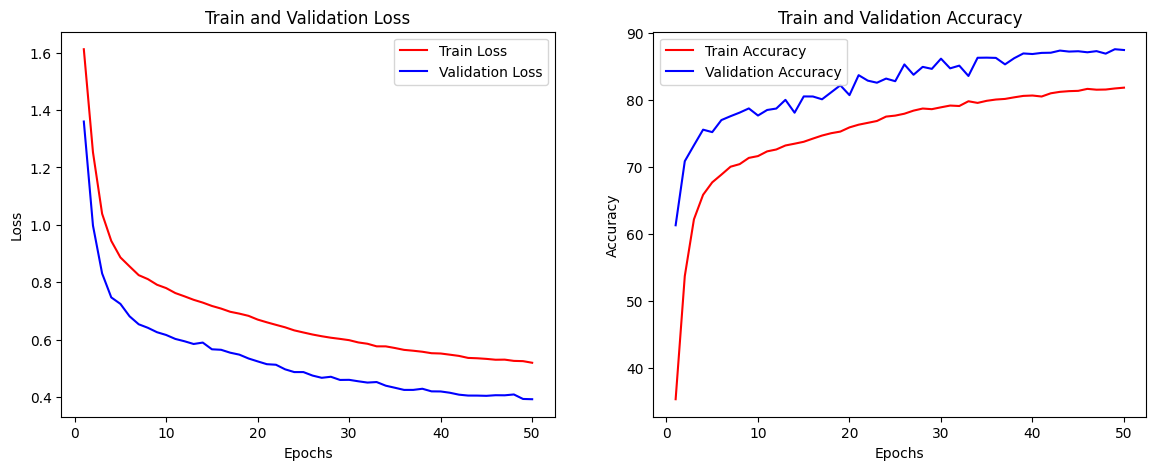

In [28]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 36 epocas porque com early stopping so rodou 36 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epocas, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
# salvando modelo
torch.save(net.state_dict(), "model/downstream_vae_10_freeze.pth")

In [37]:
# carregando modelo
model_path = "model/downstream_vae.pth"

# Criar uma instância do modelo
model_backbone = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)
net = Net(model_backbone, input_dim=input_dim).to(device)
# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
net.load_state_dict(state_dict)

<All keys matched successfully>

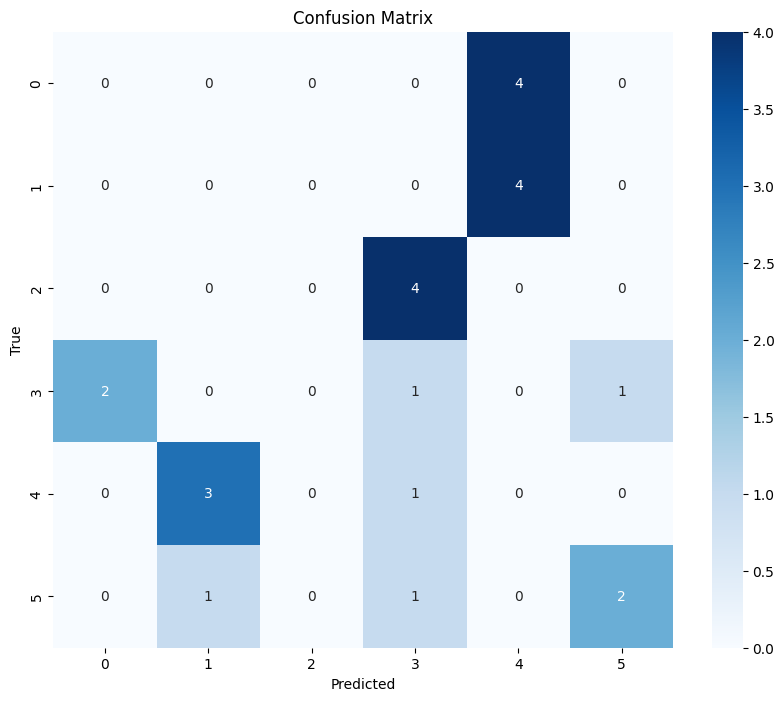

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.14      0.25      0.18         4
           4       0.00      0.00      0.00         4
           5       0.67      0.50      0.57         4

    accuracy                           0.12        24
   macro avg       0.13      0.12      0.13        24
weighted avg       0.13      0.12      0.13        24



/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [47]:
# Obter previsões do conjunto de teste
net.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        data = x.to(device)
        label = y.to(device)
        outputs = net(data)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calcular a matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print(classification_report(all_labels, all_preds))